## BASICS

We will now try to build a model that is able to predict whether an enrollee is open for a job change or not. We already know that the dataset is imbalanced: only ~25% of the observations belong to the *positive* class (= open for job change). 

Models trained on imbalanced datasets may become biased towards the majority class since there is more information available for this class. As a result, the model may struggle to accurately classify instances from the minority class.

Accuracy is a commonly used metric for evaluating classification models, but it can be misleading in imbalanced datasets. A model that predicts the majority class for every instance may achieve high accuracy, but it would not be useful in practice, especially if the goal is to correctly classify instances from the minority class.
Therefore, my goal will not be to optimize this metric.

Which metric would be more appropriate? 
Suppose this company wants to make a job offer to some of the course enrollees. However, every job offer is preceded by a closer examination of skills and also a few interviews. This process is complex and therefore expensive. The company only wants to invest this effort in enrollees who it is convinced are really willing to change their job.

In such a case, precision is the evaluation metric of choice. It indicates how accurately we predict the positive class (willing to change). It may produce some false negatives, but we can be relatively confident that the positive ones are correctly predicted.
So we try to improve the precision, but keep an eye on the other metrics.

Let's do it!

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, precision_score

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

RSEED = 15

In [2]:
# load the data
HR = pd.read_csv('data/aug_train.csv')

Based on my knowledge about the data (from the EDA) I decide to fill all NaNs in the dataset with 'MISSING'. 

I do this for the following reasons:

In some cases, the fact that the data is missing probably has a meaning: if major_discipline is missing, it is (usually) because the enrollee did or does not study. If company_size and company_type are missing, it is (probably in many cases) because the enrollee is not currently employed. If these connections exist, the model will probably recognize them at least partially. It would be fatal to simply delete the data or to impute it without further evidence with any assumptions that go beyond the simple realization of "MISSING".

In other cases, I have found no evidence that the fact that data is missing could mean something specific: e.g. in the case of gender. But I don't want to simply delete almost a quarter of my observations. Imputation with “MISSING” seems to me to be the most sensible solution here too.

In [3]:
# impute all NaNs in the dataset with 'MISSING'
HR = HR.fillna('MISSING')

Now I separate the features from the target variable:

In [4]:
#Separate training features from target
X = HR.drop(['target'], axis=1)
y = HR['target']

In [5]:
# drop enrollee_id

X = X.drop(['enrollee_id'], axis=1)

Now it's time for the train test split. Since we are dealing with an imbalanced dataset, stratified train test split is the way to go. (It'll ensure that the distribution of target classes in the training and testing sets remains similar to the original dataset.)

In [6]:
# stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
y_train.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

target
0.0    75.06%
1.0    24.94%
Name: proportion, dtype: object

In [8]:
y_test.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

target
0.0    75.08%
1.0    24.92%
Name: proportion, dtype: object

As we can see, the positive class is around 25% of the observations in both the train and the test data.

## Baseline Model

Now we build the baseline model. It's a simple Logistic Regression. The result is our benchmark which we want to improve. We use a pipeline here.

In [9]:
# create a list of categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# create a list of numerival features
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# include a step to scale the numerical
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# include a step to encode the categorical
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# create a column transformer, that combines both steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# define the model
bl_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RSEED))
])

# fit the model
bl_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['city_development_index',
                                                   'training_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'gender',
                                                   'relevent_experience',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'experience', 'company_size',
                                                   'company_type',
                                                   'last_new_job'])])),
                ('classifier', LogisticRegression(random_state=15))])

In [11]:
# make predictions on the test data
y_pred_bl = bl_model.predict(X_test)

In [12]:
#show results 
print("Accuracy:", accuracy_score(y_test, y_pred_bl).round(2))
print("Precision:", precision_score(y_test, y_pred_bl).round(2))

Accuracy: 0.78
Precision: 0.59


We are particularly interested in the precesion on target 1.0! What does a precision of 0.59 mean?

It means that (in our case: only) 59% of the positive predictions are actually positive! 

That's not a very good result. What does it all look like exactly? Let's take a look at a confusion matrix:

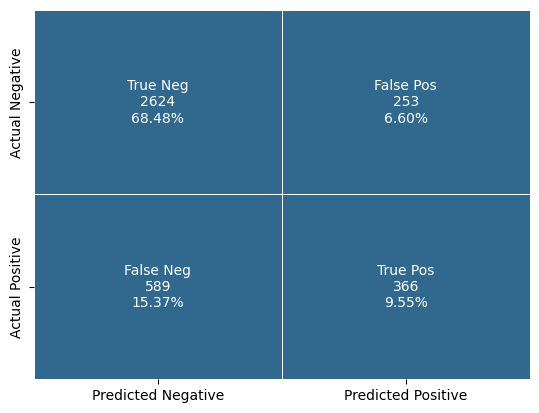

In [13]:
cfm_bl = confusion_matrix(y_test, y_pred_bl)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_bl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_bl.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_bl, annot=labels, fmt='', cmap = ['#31688e'], cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], linewidths=0.5, linecolor='white');

So the model found a total of 619 enrollees who it believes are willing to change jobs. But that actually only applies to 366 of them. 253 of these supposedly willing to change jobs don't want to change jobs!
On the other hand, 589 of those who want to change their job are not recognized. (These do not play a role in calculating the precision score, but of course this number should also go down as the model improves!)

A first step towards improvement can be to correct the imbalance in the data set. We'll try that now.

## Model

I try different models and sampling techniques to see what's most promising.

*Sampling methods work by either oversampling the minority class (increasing the number of instances from the minority class) or undersampling the majority class (reducing the number of instances from the majority class), balancing the dataset and enabling the machine learning model to learn more effectively from both classes.*

In [14]:
# models I want to test
classifiers = [
    RandomForestClassifier(random_state=RSEED),
    LogisticRegression(random_state=RSEED),
    DecisionTreeClassifier(random_state=RSEED),
    KNeighborsClassifier()]

First I check the performance per model without any oversampling.

In [15]:
for classifier in classifiers:
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
    ])
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classifier.__class__.__name__, "WITHOUT OVERSAMPLING")
    print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
    print("Precision:", precision_score(y_test, y_pred).round(2))

RandomForestClassifier WITHOUT OVERSAMPLING
Accuracy: 0.78
Precision: 0.57
LogisticRegression WITHOUT OVERSAMPLING
Accuracy: 0.78
Precision: 0.59
DecisionTreeClassifier WITHOUT OVERSAMPLING
Accuracy: 0.73
Precision: 0.46
KNeighborsClassifier WITHOUT OVERSAMPLING
Accuracy: 0.76
Precision: 0.52


Our logistic regression from the baseline model performs best.

At this point I have tried out different over/undersampling techniques with the following code:

```
sampling_methods = [
    ('RandomUnderSampler', RandomUnderSampler(random_state=RSEED)),
    ('TomekLinks', TomekLinks(sampling_strategy='auto')),
    ('NearMiss', NearMiss(version=2)),
    ('RandomOverSampler', RandomOverSampler(random_state=RSEED)),
    ('ADASYN', ADASYN(random_state=RSEED)),
    ('SMOTE', SMOTE(random_state=RSEED))
]

results_list = []

for classifier in classifiers:
    for method_name, sampler in sampling_methods:
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            (method_name, sampler),
            ('classifier', classifier)
        ])

        
        model = pipeline.fit(X_train, y_train)

        
        y_pred = model.predict(X_test)

        
        accuracy = accuracy_score(y_test, y_pred).round(2)
        precision = precision_score(y_test, y_pred).round(2)

        
        results_list.append({
            'Classifier': classifier.__class__.__name__,
            'Sampling Method': method_name,
            'Accuracy Score': accuracy,
            'Precision Score': precision
        })


results_df = pd.DataFrame(results_list)
results_df.to_csv('data/results.csv', index=False)

```

I've saved the results in a csv file and load it from there now as it takes too long to run the code block each time I restart the Kernel in this notebook.
Now let's have a look at the perfomance metrics. I sort the results by Precision Score, highest first.

In [17]:
results = pd.read_csv('data/results.csv')
results.sort_values(by='Precision Score', ascending =False)

,Classifier,Sampling Method,Accuracy Score,Precision Score
7,LogisticRegression,TomekLinks,0.80,0.61
1,RandomForestClassifier,TomekLinks,0.78,0.57
3,RandomForestClassifier,RandomOverSampler,0.79,0.57
4,RandomForestClassifier,ADASYN,0.78,0.57
5,RandomForestClassifier,SMOTE,0.78,0.57
11,LogisticRegression,SMOTE,0.78,0.54
9,LogisticRegression,RandomOverSampler,0.77,0.53
0,RandomForestClassifier,RandomUnderSampler,0.77,0.52
19,KNeighborsClassifier,TomekLinks,0.76,0.52
6,LogisticRegression,RandomUnderSampler,0.76,0.52


The best results we get from a Logistic Regression, that uses TomekLinks for undersampling. It has almost the same precision as our baseline model (also Logistic Regression), but a better accuracy.

I was actually hoping that we could improve the performance of the model even more with sampling. I'll now try to improve the performance of the Logistic Regression and the Random Forest Classifier with hyperparameter tuning and feature selection.

In [30]:
# define the Logistic Regression
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('TomekLinks', TomekLinks(sampling_strategy='auto')),
    ('log_reg', LogisticRegression(random_state=RSEED))
])

In [31]:
# cross validation

y_hat_log_reg_cv = cross_val_predict(log_reg, X_train, y_train, cv=5)
print("Accuracy Logistic Regression (CV):", accuracy_score(y_train, y_hat_log_reg_cv).round(2))
print("Precision Logistic Regression (CV):", precision_score(y_train, y_hat_log_reg_cv).round(2))

Accuracy Logistic Regression (CV): 0.79
Precision Logistic Regression (CV): 0.59


In [32]:
# fit the model
log_reg.fit(X_train, y_train)

# predict
y_hat_log_reg = log_reg.predict(X_test)
print("Accuracy Logistic Regression (test data):", accuracy_score(y_test, y_hat_log_reg).round(2))
print("Precision Logistic Regression (test data):", precision_score(y_test, y_hat_log_reg).round(2))

Accuracy Logistic Regression (test data): 0.8
Precision Logistic Regression (test data): 0.61


In [22]:
# define a dictionay of hyperparameters that I want to test in a randomized search
param_dist_log_reg = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'log_reg__fit_intercept': [True, False],
    'log_reg__class_weight': [None, 'balanced'],
    'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'log_reg__max_iter': [50, 100, 200, 300, 500]
}

In [23]:
# the next steps I comment out so they don't run each time I start the Kernel

# random_search_log_reg = RandomizedSearchCV(log_reg, param_distributions=param_dist_log_reg, n_iter=10, cv=5,  scoring='precision',random_state=RSEED, refit='precision')
# random_search_log_reg.fit(X_train, y_train)

# print("Best Parameters: ", random_search_log_reg.best_params_)
# print("Best Precision: ", random_search_log_reg.best_score_)

Best Parameters:  {'log_reg__solver': 'liblinear', 'log_reg__penalty': 'l2', 'log_reg__max_iter': 100, 'log_reg__fit_intercept': False, 'log_reg__class_weight': None, 'log_reg__C': 0.1}
Best Precision:  0.5956248405660148


These are the best parameters that were found, but they actually haven't improved the performance of the model on the test data:

```
Best Parameters:  {'log_reg__solver': 'liblinear', 'log_reg__penalty': 'l2', 'log_reg__max_iter': 100, 'log_reg__fit_intercept': False, 'log_reg__class_weight': None, 'log_reg__C': 0.1}
Best Precision:  0.5956248405660148
```

```
solver= 'liblinear', penalty= 'l2', max_iter= 100, fit_intercept= False, class_weight= None, C= 0.1,
````

<Axes: ylabel='Feature'>

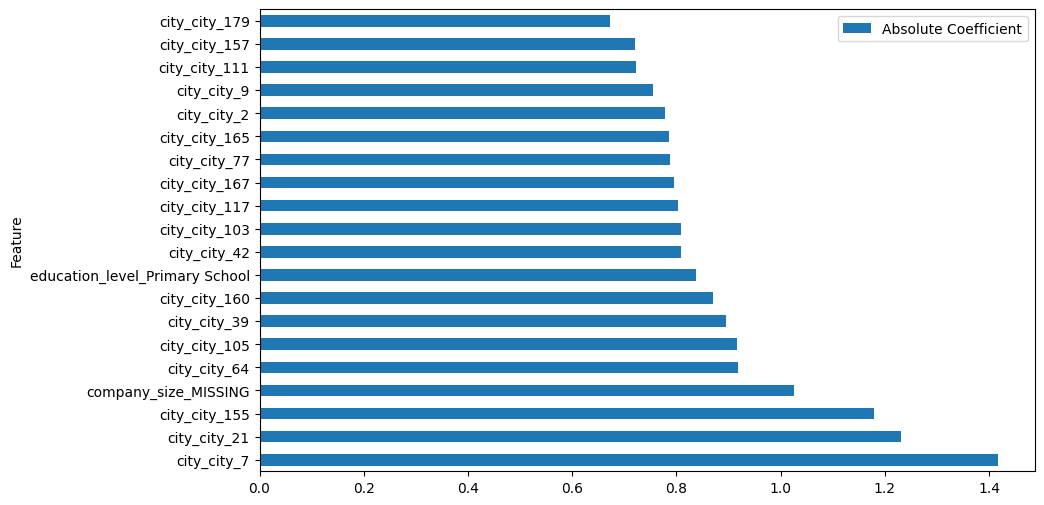

In [67]:
feature_names = (log_reg.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(input_features=categorical_features))

# Concatenate numeric and one-hot encoded feature names
all_feature_names = np.concatenate([numeric_features, feature_names])

# Extract coefficients from the logistic regression model
absolute_coefficients = np.abs(log_reg.named_steps['log_reg'].coef_[0])

# Display feature importance (absolute values)
feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Absolute Coefficient': absolute_coefficients})
feature_importance = feature_importance.sort_values('Absolute Coefficient', ascending=False).head(20)
feature_importance.plot(x='Feature', y='Absolute Coefficient', kind='barh', figsize=(10, 6))

In [40]:
# define the random forest
forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('TomekLinks', TomekLinks(sampling_strategy='auto')),
    ('forest', RandomForestClassifier(bootstrap= True, class_weight= None, criterion= 'gini', max_depth= 30, max_features= 'log2', min_samples_leaf= 18, min_samples_split= 4, n_estimators= 97, random_state=RSEED))
])

In [41]:
# cross validation

y_hat_forest_cv = cross_val_predict(forest, X_train, y_train, cv=5)
print("Accuracy Random Forest (CV):", accuracy_score(y_train, y_hat_forest_cv).round(2))
print("Precision Random Forest (CV):", precision_score(y_train, y_hat_forest_cv).round(2))

Accuracy Random Forest (CV): 0.76
Precision Random Forest (CV): 0.6


In [42]:
# fit the model
forest.fit(X_train, y_train)

# predict
y_hat_forest = forest.predict(X_test)
print("Accuracy Random Forest:", accuracy_score(y_test, y_hat_forest).round(2))
print("Precision Random Forest:", precision_score(y_test, y_hat_forest).round(2))

Accuracy Random Forest: 0.77
Precision Random Forest: 0.61


In [37]:
# define a dictionay of hyperparameters that I want to test in a randomized search
from scipy.stats import randint
param_dist_forest = {
    'forest__n_estimators': randint(10, 200),  
    'forest__max_features': ['auto', 'sqrt', 'log2', None],  
    'forest__max_depth': [None, 10, 20, 30, 40, 50],  
    'forest__min_samples_split': randint(2, 20),  
    'forest__min_samples_leaf': randint(1, 20),  
    'forest__bootstrap': [True, False],  
    'forest__criterion': ['gini', 'entropy'],  
    'forest__class_weight': [None, 'balanced', 'balanced_subsample'],  
}

In [39]:
# the next steps I comment out so they don't run each time I start the Kernel

# random_search_forest = RandomizedSearchCV(forest, param_distributions=param_dist_forest, n_iter=10, cv=5,  scoring='precision',random_state=RSEED, refit='precision')
# random_search_forest.fit(X_train, y_train)

# print("Best Parameters: ", random_search_forest.best_params_)
# print("Best Precision: ", random_search_forest.best_score_)

These are the best parameters that were found, I already added them to the model above:

```
Best Parameters:  {'forest__bootstrap': True, 'forest__class_weight': None, 'forest__criterion': 'gini', 'forest__max_depth': 30, 'forest__max_features': 'log2', 'forest__min_samples_leaf': 18, 'forest__min_samples_split': 4, 'forest__n_estimators': 97}
Best Precision:  0.606951072235945
```

```
bootstrap= True, class_weight= None, criterion= 'gini', max_depth= 30, max_features= 'log2', min_samples_leaf= 18, min_samples_split= 4, n_estimators= 97
```

The improvement of the models through hyperparameter tuning is very modest - unfortunately. 

Time to take another look at the features. Maybe we can throw out a few more?

We saw in the EDA that the following features weren't important: gender, training_hours. Also company_size wasn't important. The only relevant info here was if the size was missing. But this info is also included in the more relevant company_type column which I keep.